### Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2DTranspose, Reshape, concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

In [2]:
# Set up the dataset path
dataset_path = '.'

# Set up saving figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "InceptionResNetV2-MTL"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)  # create the sub-folders if they do not exist

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

print('> SETUP Done: all saved files are accessible in ', IMAGES_PATH)


# Setting all the parameters or hyperparameters
img_size = 128
test_size = 0.3
random_state = 42
validation_split = 0.2
epochs = 30
batch_size = 32
learning_rate = 0.0001

> SETUP Done: all saved files are accessible in  .\images\InceptionResNetV2-MTL


### Loading & preprocessing Data

In [3]:
# DATA LOADING & PREPROCESSING
def load_and_preprocess(img_size, test_size, random_state, date):
    print('> Loading data ...')
    data = np.load(f'{dataset_path}/twri_rgb_6832_cotton_{img_size}x{img_size}_{date}.npy')
    labels = pd.read_excel(f'{dataset_path}/labels_rgb.xlsx')
    print("Shape of data images:", data.shape)
    print(f"Shape of labeled data: {labels.shape[0]}:{labels.shape[1]}, header: {labels.columns}")
    y_label = labels['class'].values

    print('> Data and labels loaded')
    print('> Preprocessing Data: remove filler class + Split train/test + Normalization ...')

    # Adjusting size mismatch between data and labels
    min_length = min(data.shape[0], y_label.shape[0])
    data = data[:min_length]
    y_label = y_label[:min_length]

    # Remove filler class (class 0)
    valid_idx = y_label != 0
    data = data[valid_idx]
    y_label = y_label[valid_idx] - 1  # Adjust class index to start from 0

    # Define class names
    class_names = ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']
    print('Concerned classes: ', class_names)

    # Split data into train and test sets
    train_images, test_images, train_labels, test_labels = train_test_split(data, y_label, test_size=test_size, random_state=random_state)

    # Normalize images
    train_images, test_images = train_images / 255.0, test_images / 255.0

    print('> Data Preprocessing Done')
    return train_images, test_images, train_labels, test_labels, class_names

# Execute an example
date_ex = "8_18"
train_images, test_images, train_labels, test_labels, class_names = load_and_preprocess(img_size, test_size, random_state, date_ex)

> Loading data ...
Shape of data images: (6840, 128, 128, 3)
Shape of labeled data: 6832:3, header: Index(['FID', 'treatment', 'class'], dtype='object')
> Data and labels loaded
> Preprocessing Data: remove filler class + Split train/test + Normalization ...
Concerned classes:  ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']
> Data Preprocessing Done


### Build & Train the model
 

In [ ]:
# Build Multi-Task Model
def build_and_train_mtl_model(img_size, train_images, train_labels, validation_split, epochs, batch_size, learning_rate):
    print('> Building the Multi-Task Learning (MTL) model ...')

    # Input layer
    input_layer = Input(shape=(img_size, img_size, 3))

    # Base model (shared backbone)
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)
    
    for layer in base_model.layers[:-50]:  # Freeze all but the last 50 layers
        layer.trainable = False

    # Shared layers
    x = base_model.output
    shared_features = GlobalAveragePooling2D()(x)

    # Denoising Head: decoder
    denoising_head = Conv2DTranspose(512, (3, 3), activation='relu', strides=(2, 2), padding='same')(base_model.output)  # 4x4x512
    denoising_head = Conv2DTranspose(256, (3, 3), activation='relu', strides=(2, 2), padding='same')(denoising_head)    # 8x8x256
    denoising_head = Conv2DTranspose(128, (3, 3), activation='relu', strides=(2, 2), padding='same')(denoising_head)    # 16x16x128
    denoising_head = Conv2DTranspose(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(denoising_head)     # 32x32x64
    denoising_head = Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(denoising_head)     # 64x64x32
    denoising_head = Conv2DTranspose(3, (3, 3), activation='sigmoid', strides=(2, 2), padding='same', name='denoised_image')(denoising_head)  # 128x128x3


    # Classification Head
    classification_head = Dropout(0.4)(shared_features)
    classification_head = Dense(256, activation='relu')(classification_head)
    classification_head = Dropout(0.3)(classification_head)
    classification_head = Dense(len(class_names), activation='softmax', name='class_output')(classification_head)

    # Combine both tasks into the MTL model
    model = Model(inputs=input_layer, outputs=[denoising_head, classification_head])

    # Checking the input/output shapes
    print("Base model output shape:", base_model.output.shape)
    print("Denoising head output shape:", denoising_head.shape)
    print("Expected ground truth shape:", train_images.shape)


    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss={'denoised_image': 'mse', 'class_output': 'sparse_categorical_crossentropy'},
                  metrics={'denoised_image': 'mse', 'class_output': 'accuracy'})

    print('> Training the MTL model...')
    # Train the model
    history = model.fit(train_images,
                        {'denoised_image': train_images, 'class_output': train_labels},
                        validation_split=validation_split,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)

    print('> End of MTL Training!')
    return model, history

# Execute the MTL model
mtl_model, mtl_history = build_and_train_mtl_model(img_size, train_images, train_labels, validation_split, epochs, batch_size, learning_rate)


> Building the Multi-Task Learning (MTL) model ...
Base model output shape: (None, 2, 2, 1536)
Denoising head output shape: (None, 128, 128, 3)
Expected ground truth shape: (3763, 128, 128, 3)
> Training the MTL model...
Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - class_output_accuracy: 0.3708 - class_output_loss: 1.3695 - denoised_image_loss: 0.0424 - denoised_image_mse: 0.0424 - loss: 1.4119 - val_class_output_accuracy: 0.5339 - val_class_output_loss: 1.0747 - val_denoised_image_loss: 0.0369 - val_denoised_image_mse: 0.0369 - val_loss: 1.1111
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - class_output_accuracy: 0.5925 - class_output_loss: 0.9345 - denoised_image_loss: 0.0318 - denoised_image_mse: 0.0318 - loss: 0.9663 - val_class_output_accuracy: 0.6375 - val_class_output_loss: 0.8445 - val_denoised_image_loss: 0.0205 - val_denoised_image_mse: 0.0205 - val_loss: 0.8637
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - class_output_accuracy: 0.7228 - class_output_los

### Model Evaluation

In [7]:
# MODEL EVALUATION
def evaluate_model(model, test_images, test_labels, date, history, baseline_performance=None):
    print('> Evaluating the model ...')

    # Create output directory for the evaluation results
    eval_dir = f"{IMAGES_PATH}/Evaluation_{date}"
    os.makedirs(eval_dir, exist_ok=True)

    # Evaluate the model
    results = model.evaluate(test_images, {'denoised_image': test_images, 'class_output': test_labels}, verbose=2, return_dict=True)
    classification_accuracy = results['class_output_accuracy']
    denoising_loss = results['denoised_image_loss']
    print(f"Classification Test Accuracy: {classification_accuracy:.2f}")
    print(f"Denoising Loss: {denoising_loss:.4f}")

    # Compare with baseline performance if available
    if baseline_performance:
        print("\n> Relative Performance Comparison:")
        baseline_accuracy = baseline_performance.get('accuracy', None)
        baseline_loss = baseline_performance.get('loss', None)

        if baseline_accuracy:
            acc_diff = classification_accuracy - baseline_accuracy
            print(f"Classification Accuracy Change: {acc_diff:+.2f}")

        if baseline_loss:
            loss_diff = baseline_loss - denoising_loss
            print(f"Denoising Loss Improvement: {loss_diff:+.4f}")

    # Predictions and classification report
    predictions = model.predict(test_images)
    pred_classes = np.argmax(predictions[1], axis=1)  # [1] for classification head output

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(test_labels, pred_classes, display_labels=class_names)
    plt.title(f"Confusion Matrix - {date}")
    plt.savefig(f"{eval_dir}/Confusion_Matrix_{date}.png")
    plt.close()

    # Classification report
    report = classification_report(test_labels, pred_classes, target_names=class_names)
    print("\nClassification Report:\n", report)

    # Save the classification report
    report_path = f"{eval_dir}/Classification_Report_{date}.txt"
    with open(report_path, "w") as f:
        f.write(report)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.savefig(f"{eval_dir}/Training_Validation_Accuracy_{date}.png")
    plt.close()

    # Plot training and validation loss for both heads
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['denoised_image_loss'], label='Denoising Loss (Train)')
    plt.plot(history.history['val_denoised_image_loss'], label='Denoising Loss (Validation)')
    plt.plot(history.history['class_output_loss'], label='Classification Loss (Train)')
    plt.plot(history.history['val_class_output_loss'], label='Classification Loss (Validation)')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.savefig(f"{eval_dir}/Training_Validation_Losses_{date}.png")
    plt.close()

    # Save the evaluation summary to a file
    summary_path = f"{eval_dir}/Evaluation_Summary_{date}.txt"
    with open(summary_path, "w") as f:
        f.write(f"Classification Test Accuracy: {classification_accuracy:.2f}\n")
        f.write(f"Denoising Loss: {denoising_loss:.4f}\n")
        if baseline_performance:
            if baseline_accuracy:
                f.write(f"Classification Accuracy Change: {acc_diff:+.2f}\n")
            if baseline_loss:
                f.write(f"Denoising Loss Improvement: {loss_diff:+.4f}\n")
        f.write("\nClassification Report:\n")
        f.write(report)

    print(f"> Evaluation complete! Results saved in {eval_dir}.")

# Example usage:
# Pass baseline_performance as a dictionary containing metrics from a previous model, e.g.,
# baseline_performance = {'accuracy': 0.85, 'loss': 0.08}
evaluate_model(mtl_model, test_images, test_labels, date_ex, mtl_history, baseline_performance=None)

> Evaluating the model ...
51/51 - 16s - 311ms/step - class_output_accuracy: 0.7148 - class_output_loss: 1.4291 - denoised_image_loss: 0.0123 - denoised_image_mse: 0.0123 - loss: 1.4417
Classification Test Accuracy: 0.71
Denoising Loss: 0.0123
51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 471ms/step

Classification Report:
                  precision    recall  f1-score   support

        rainfed       0.79      0.75      0.77       424
fully irrigated       0.85      0.79      0.82       399
percent deficit       0.60      0.56      0.58       404
     time delay       0.63      0.76      0.69       386

       accuracy                           0.71      1613
      macro avg       0.72      0.72      0.71      1613
   weighted avg       0.72      0.71      0.72      1613

> Evaluation complete! Results saved in .\images\InceptionResNetV2-MTL/Evaluation_8_18.


### Individual Test Example: Predictions

> Visualizing the Results ...
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 311ms/step


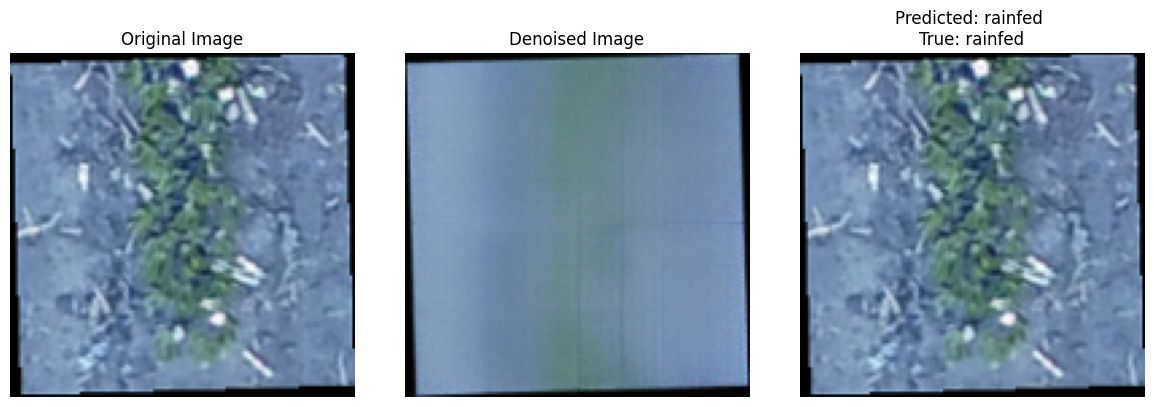

Denoising MSE: 0.0108


In [9]:
# Evaluate and Visualize Results
def visualize_results(mtl_model, test_images, test_labels, class_names):
    print('> Visualizing the Results ...')

    # Predict outputs
    denoised_images, class_predictions = mtl_model.predict(test_images)
    predicted_classes = np.argmax(class_predictions, axis=1)

    # Select a random test image
    idx = np.random.randint(len(test_images))
    original = test_images[idx]
    denoised = denoised_images[idx]
    predicted_class = class_names[predicted_classes[idx]]
    true_class = class_names[test_labels[idx]]

    # Plot the original, noised, and denoised images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Denoised Image')
    plt.imshow(denoised)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f'Predicted: {predicted_class} \nTrue: {true_class}')
    plt.imshow(original)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print denoising improvement
    denoising_error = np.mean((original - denoised)**2)
    print(f"Denoising MSE: {denoising_error:.4f}")

visualize_results(mtl_model, test_images, test_labels, class_names)